In [12]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets  # interactive display

In [13]:
from matplotlib import ticker

def plot_value_function(V, ax=None, show=True):
    """Plot V(s), the value function"""
    if not ax:
        fig, ax = plt.subplots()

    ax.stem(V)
    ax.set_ylabel('Value')
    ax.set_xlabel('State')
    ax.set_title("Value function: $V(s)$")

    if show:
        plt.show()


def plot_tde_trace(TDE, ax=None, show=True, skip=400):
    """Plot the TD Error across trials"""
    if not ax:
        fig, ax = plt.subplots()

    indx = np.arange(0, TDE.shape[1], skip)
    im = ax.imshow(TDE[:,indx])
    positions = ax.get_xticks()
    # Avoid warning when setting string tick labels
    ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax.set_xticklabels([f"{int(skip * x)}" for x in positions])
    ax.set_title('TD-error over learning')
    ax.set_ylabel('State')
    ax.set_xlabel('Iterations')
    ax.figure.colorbar(im)
    if show:
        plt.show()


def learning_summary_plot(V, TDE):
    """Summary plot for Ex1"""
    fig, (ax1, ax2) = plt.subplots(nrows = 2, gridspec_kw={'height_ratios': [1, 2]})

    plot_value_function(V, ax=ax1, show=False)
    plot_tde_trace(TDE, ax=ax2, show=False)
    plt.tight_layout()
    plt.show()

In [14]:
def reward_guesser_title_hint(r1, r2):
    """"Provide a mildly obfuscated hint for a demo."""
    if (r1==14 and r2==6) or (r1==6 and r2==14):
        return "Technically correct...(the best kind of correct)"

    if  ~(~(r1+r2) ^ 11) - 1 == (6 | 24): # Don't spoil the fun :-)
        return "Congratulations! You solved it!"

    return "Keep trying...."


class ClassicalConditioning:

    def __init__(self, n_steps, reward_magnitude, reward_time):

        # Task variables
        self.n_steps = n_steps
        self.n_actions = 0
        self.cs_time = int(n_steps/4) - 1

        # Reward variables
        self.reward_state = [0,0]
        self.reward_magnitude = None
        self.reward_probability = None
        self.reward_time = None

        # Time step at which the conditioned stimulus is presented
        self.set_reward(reward_magnitude, reward_time)

        # Create a state dictionary
        self._create_state_dictionary()

    def set_reward(self, reward_magnitude, reward_time):

        """
        Determine reward state and magnitude of reward
        """
        if reward_time >= self.n_steps - self.cs_time:
            self.reward_magnitude = 0

        else:
            self.reward_magnitude = reward_magnitude
            self.reward_state = [1, reward_time]

    def get_outcome(self, current_state):

        """
        Determine next state and reward
        """
        # Update state
        if current_state < self.n_steps - 1:
            next_state = current_state + 1
        else:
            next_state = 0

        # Check for reward
        if self.reward_state == self.state_dict[current_state]:
            reward = self.reward_magnitude
        else:
            reward = 0

        return next_state, reward

    def _create_state_dictionary(self):

        """
        This dictionary maps number of time steps/ state identities
        in each episode to some useful state attributes:

        state      - 0 1 2 3 4 5 (cs) 6 7 8 9 10 11 12 ...
        is_delay   - 0 0 0 0 0 0 (cs) 1 1 1 1  1  1  1 ...
        t_in_delay - 0 0 0 0 0 0 (cs) 1 2 3 4  5  6  7 ...
        """
        d = 0

        self.state_dict = {}
        for s in range(self.n_steps):
            if s <= self.cs_time:
                self.state_dict[s] = [0,0]
            else:
                d += 1 # Time in delay
                self.state_dict[s] = [1,d]


class MultiRewardCC(ClassicalConditioning):
    """Classical conditioning paradigm, except that one randomly selected reward,
      magnitude, from a list, is delivered of a single fixed reward."""
    def __init__(self, n_steps, reward_magnitudes, reward_time=None):
        """"Build a multi-reward classical conditioning environment
          Args:
            - nsteps: Maximum number of steps
            - reward_magnitudes: LIST of possible reward magnitudes.
            - reward_time: Single fixed reward time
          Uses numpy global random state.
          """
        super().__init__(n_steps, 1, reward_time)
        self.reward_magnitudes = reward_magnitudes

    def get_outcome(self, current_state):
        next_state, reward = super().get_outcome(current_state)
        if reward:
            reward=np.random.choice(self.reward_magnitudes)
        return next_state, reward


class ProbabilisticCC(ClassicalConditioning):
    """Classical conditioning paradigm, except that rewards are stochastically omitted."""
    def __init__(self, n_steps, reward_magnitude, reward_time=None, p_reward=0.75):
        """"Build a multi-reward classical conditioning environment
          Args:
            - nsteps: Maximum number of steps
            - reward_magnitudes: Reward magnitudes.
            - reward_time: Single fixed reward time.
            - p_reward: probability that reward is actually delivered in rewarding state
          Uses numpy global random state.
          """
        super().__init__(n_steps, reward_magnitude, reward_time)
        self.p_reward = p_reward

    def get_outcome(self, current_state):
        next_state, reward = super().get_outcome(current_state)
        if reward:
            reward*= int(np.random.uniform(size=1)[0] < self.p_reward)
        return next_state, reward

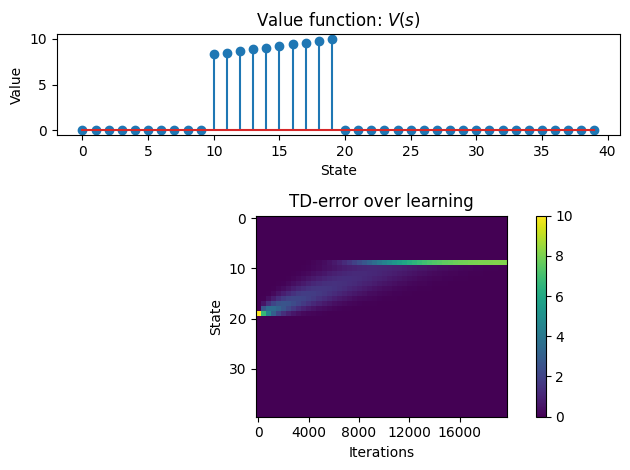

In [15]:
def td_learner(env, n_trials, gamma=0.98, alpha=0.001):
    """ Temporal Difference learning
  
    Args:
      env (object): the environment to be learned
      n_trials (int): the number of trials to run
      gamma (float): temporal discount factor
      alpha (float): learning rate
  
    Returns:
      ndarray, ndarray: the value function and temporal difference error arrays
    """
    V = np.zeros(env.n_steps) # Array to store values over states (time)
    TDE = np.zeros((env.n_steps, n_trials)) # Array to store TD errors

    for n in range(n_trials):

        state = 0 # Initial state

        for t in range(env.n_steps):

            # Get next state and next reward
            next_state, reward = env.get_outcome(state)

            # Is the current state in the delay period (after CS)?
            is_delay = env.state_dict[state][0]

            # Write an expression to compute the TD-error
            TDE[state, n] = reward + gamma * V[next_state] - V[state]

            # Write an expression to update the value function
            V[state] += is_delay * alpha * TDE[state, n]

            # Update state
            state = next_state

    return V, TDE


# Initialize classical conditioning class
env = ClassicalConditioning(n_steps=40, reward_magnitude=10, reward_time=10)

# Perform temporal difference learning
V, TDE = td_learner(env, n_trials=20000)

# Visualize
learning_summary_plot(V, TDE)

In [16]:
n_trials = 20000

@widgets.interact
def plot_tde_by_trial(trial = widgets.IntSlider(value=5000, min=0, max=n_trials-1 , step=1, description="Trial #")):
    if 'TDE' not in globals():
        print("Complete Exercise 1 to enable this interactive demo!")
    else:

        fig, ax = plt.subplots()
        ax.axhline(0, color='k') # Use this + basefmt=' ' to keep the legend clean.
        ax.stem(TDE[:, 0], linefmt='C1-', markerfmt='C1d', basefmt=' ',
                label="Before Learning (Trial 0)")
        ax.stem(TDE[:, -1], linefmt='C2-', markerfmt='C2s', basefmt=' ',
                label=r"After Learning (Trial $\infty$)")
        ax.stem(TDE[:, trial], linefmt='C0-', markerfmt='C0o', basefmt=' ',
                label=f"Trial {trial}")

        ax.set_xlabel("State in trial")
        ax.set_ylabel("TD Error")
        ax.set_title("Temporal Difference Error by Trial")
        ax.legend()
        plt.show()

interactive(children=(IntSlider(value=5000, description='Trial #', max=19999), Output()), _dom_classes=('widge…

In [17]:
@widgets.interact
def plot_summary_alpha_gamma(alpha=widgets.FloatSlider(value=0.0001, min=0.0001,
                                                       max=0.1, step=0.0001,
                                                       readout_format='.4f',
                                                       description="alpha"),
                             gamma=widgets.FloatSlider(value=0.980, min=0,
                                                       max=1.1, step=0.010, \
                                                       description="γ")):
    env = ClassicalConditioning(n_steps=40, reward_magnitude=10, reward_time=10)
    try:
        V_params, TDE_params = td_learner(env, n_trials=20000, gamma=gamma,
                                          alpha=alpha)
    except NotImplementedError:
        print("Finish Exercise 1 to enable this interactive demo")

    learning_summary_plot(V_params,TDE_params)

interactive(children=(FloatSlider(value=0.0001, description='alpha', max=0.1, min=0.0001, readout_format='.4f'…

In [15]:
n_trials = 20000
np.random.seed(2020)
rng_state = np.random.get_state()
env = MultiRewardCC(40, [6, 14], reward_time=10)
V_multi, TDE_multi = td_learner(env, n_trials, gamma=0.98, alpha=0.001)

@widgets.interact
def reward_guesser_interaction(r1 = widgets.IntText(value=0, min=0, max=50, description="Reward 1"),
                               r2 = widgets.IntText(value=0, min=0, max=50, description="Reward 2")):
    try:
        env2 = MultiRewardCC(40, [r1, r2], reward_time=10)
        V_guess, _ = td_learner(env2, n_trials, gamma=0.98, alpha=0.001)
        fig, ax = plt.subplots()
        m, l, _ = ax.stem(V_multi, linefmt='y-', markerfmt='yo',
                          basefmt=' ', label="Target")
        m.set_markersize(15)
        m.set_markerfacecolor('none')
        l.set_linewidth(4)
        m, _, _ = ax.stem(V_guess, linefmt='r', markerfmt='rx',
                          basefmt=' ', label="Guess")
        m.set_markersize(15)

        ax.set_xlabel("State")
        ax.set_ylabel("Value")
        ax.set_title(f"Guess V(s)\n{reward_guesser_title_hint(r1, r2)}")
        ax.legend()
        plt.show()
    except NotImplementedError:
        print("Please finish Exercise 1 first!")

interactive(children=(IntText(value=0, description='Reward 1'), IntText(value=0, description='Reward 2'), Outp…

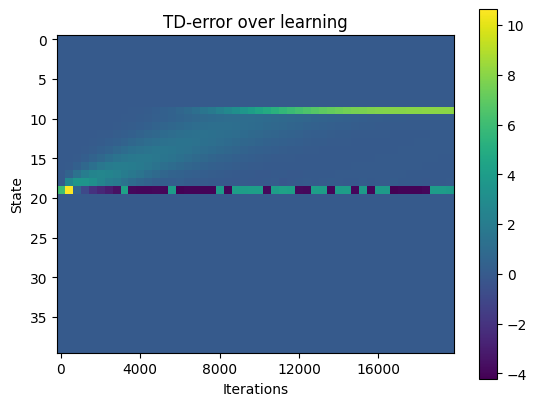

In [16]:
plot_tde_trace(TDE_multi)


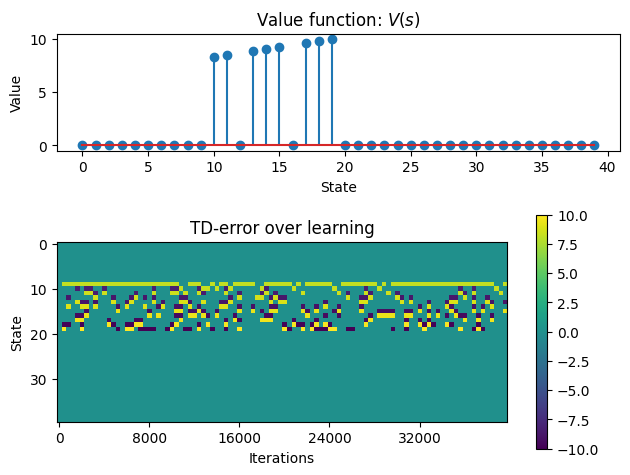

In [17]:
np.random.set_state(rng_state)  # Resynchronize everyone's notebooks
n_trials = 20000
try:
    env = ProbabilisticCC(n_steps=40, reward_magnitude=10, reward_time=10,
                          p_reward=0.8)
    V_stochastic, TDE_stochastic = td_learner(env, n_trials*2, alpha=1)
    learning_summary_plot(V_stochastic, TDE_stochastic)
except NotImplementedError:
    print("Please finish Exercise 1 first")

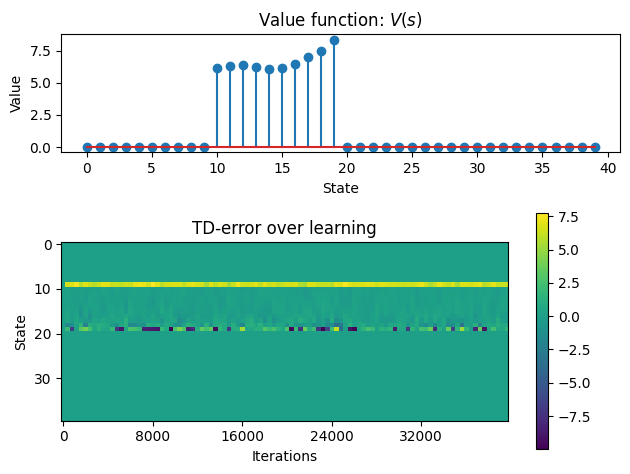

In [18]:
np.random.set_state(rng_state)  # Resynchronize everyone's notebooks
n_trials = 20000
try:
    env = ProbabilisticCC(n_steps=40, reward_magnitude=10, reward_time=10,
                          p_reward=0.8)
    V_stochastic, TDE_stochastic = td_learner(env, n_trials*2, alpha=.2)
    learning_summary_plot(V_stochastic, TDE_stochastic)
except NotImplementedError:
    print("Please finish Exercise 1 first")